Highest score: 13.176994013008901


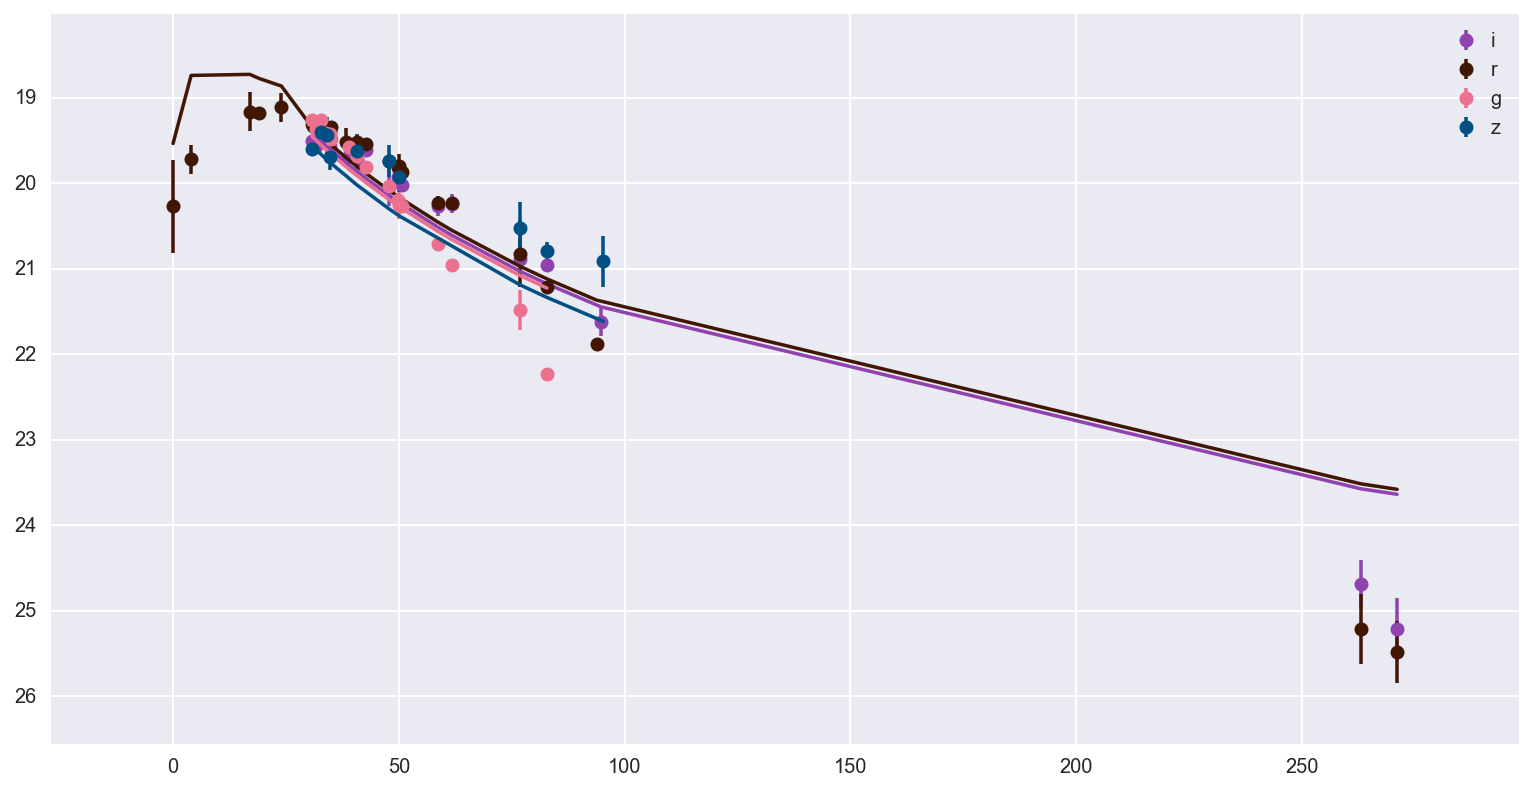

Preparing corner plot, takes some time.


/Users/matt/software_installations/anaconda3/lib/python3.5/site-packages/matplotlib/mathtext.py:857: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


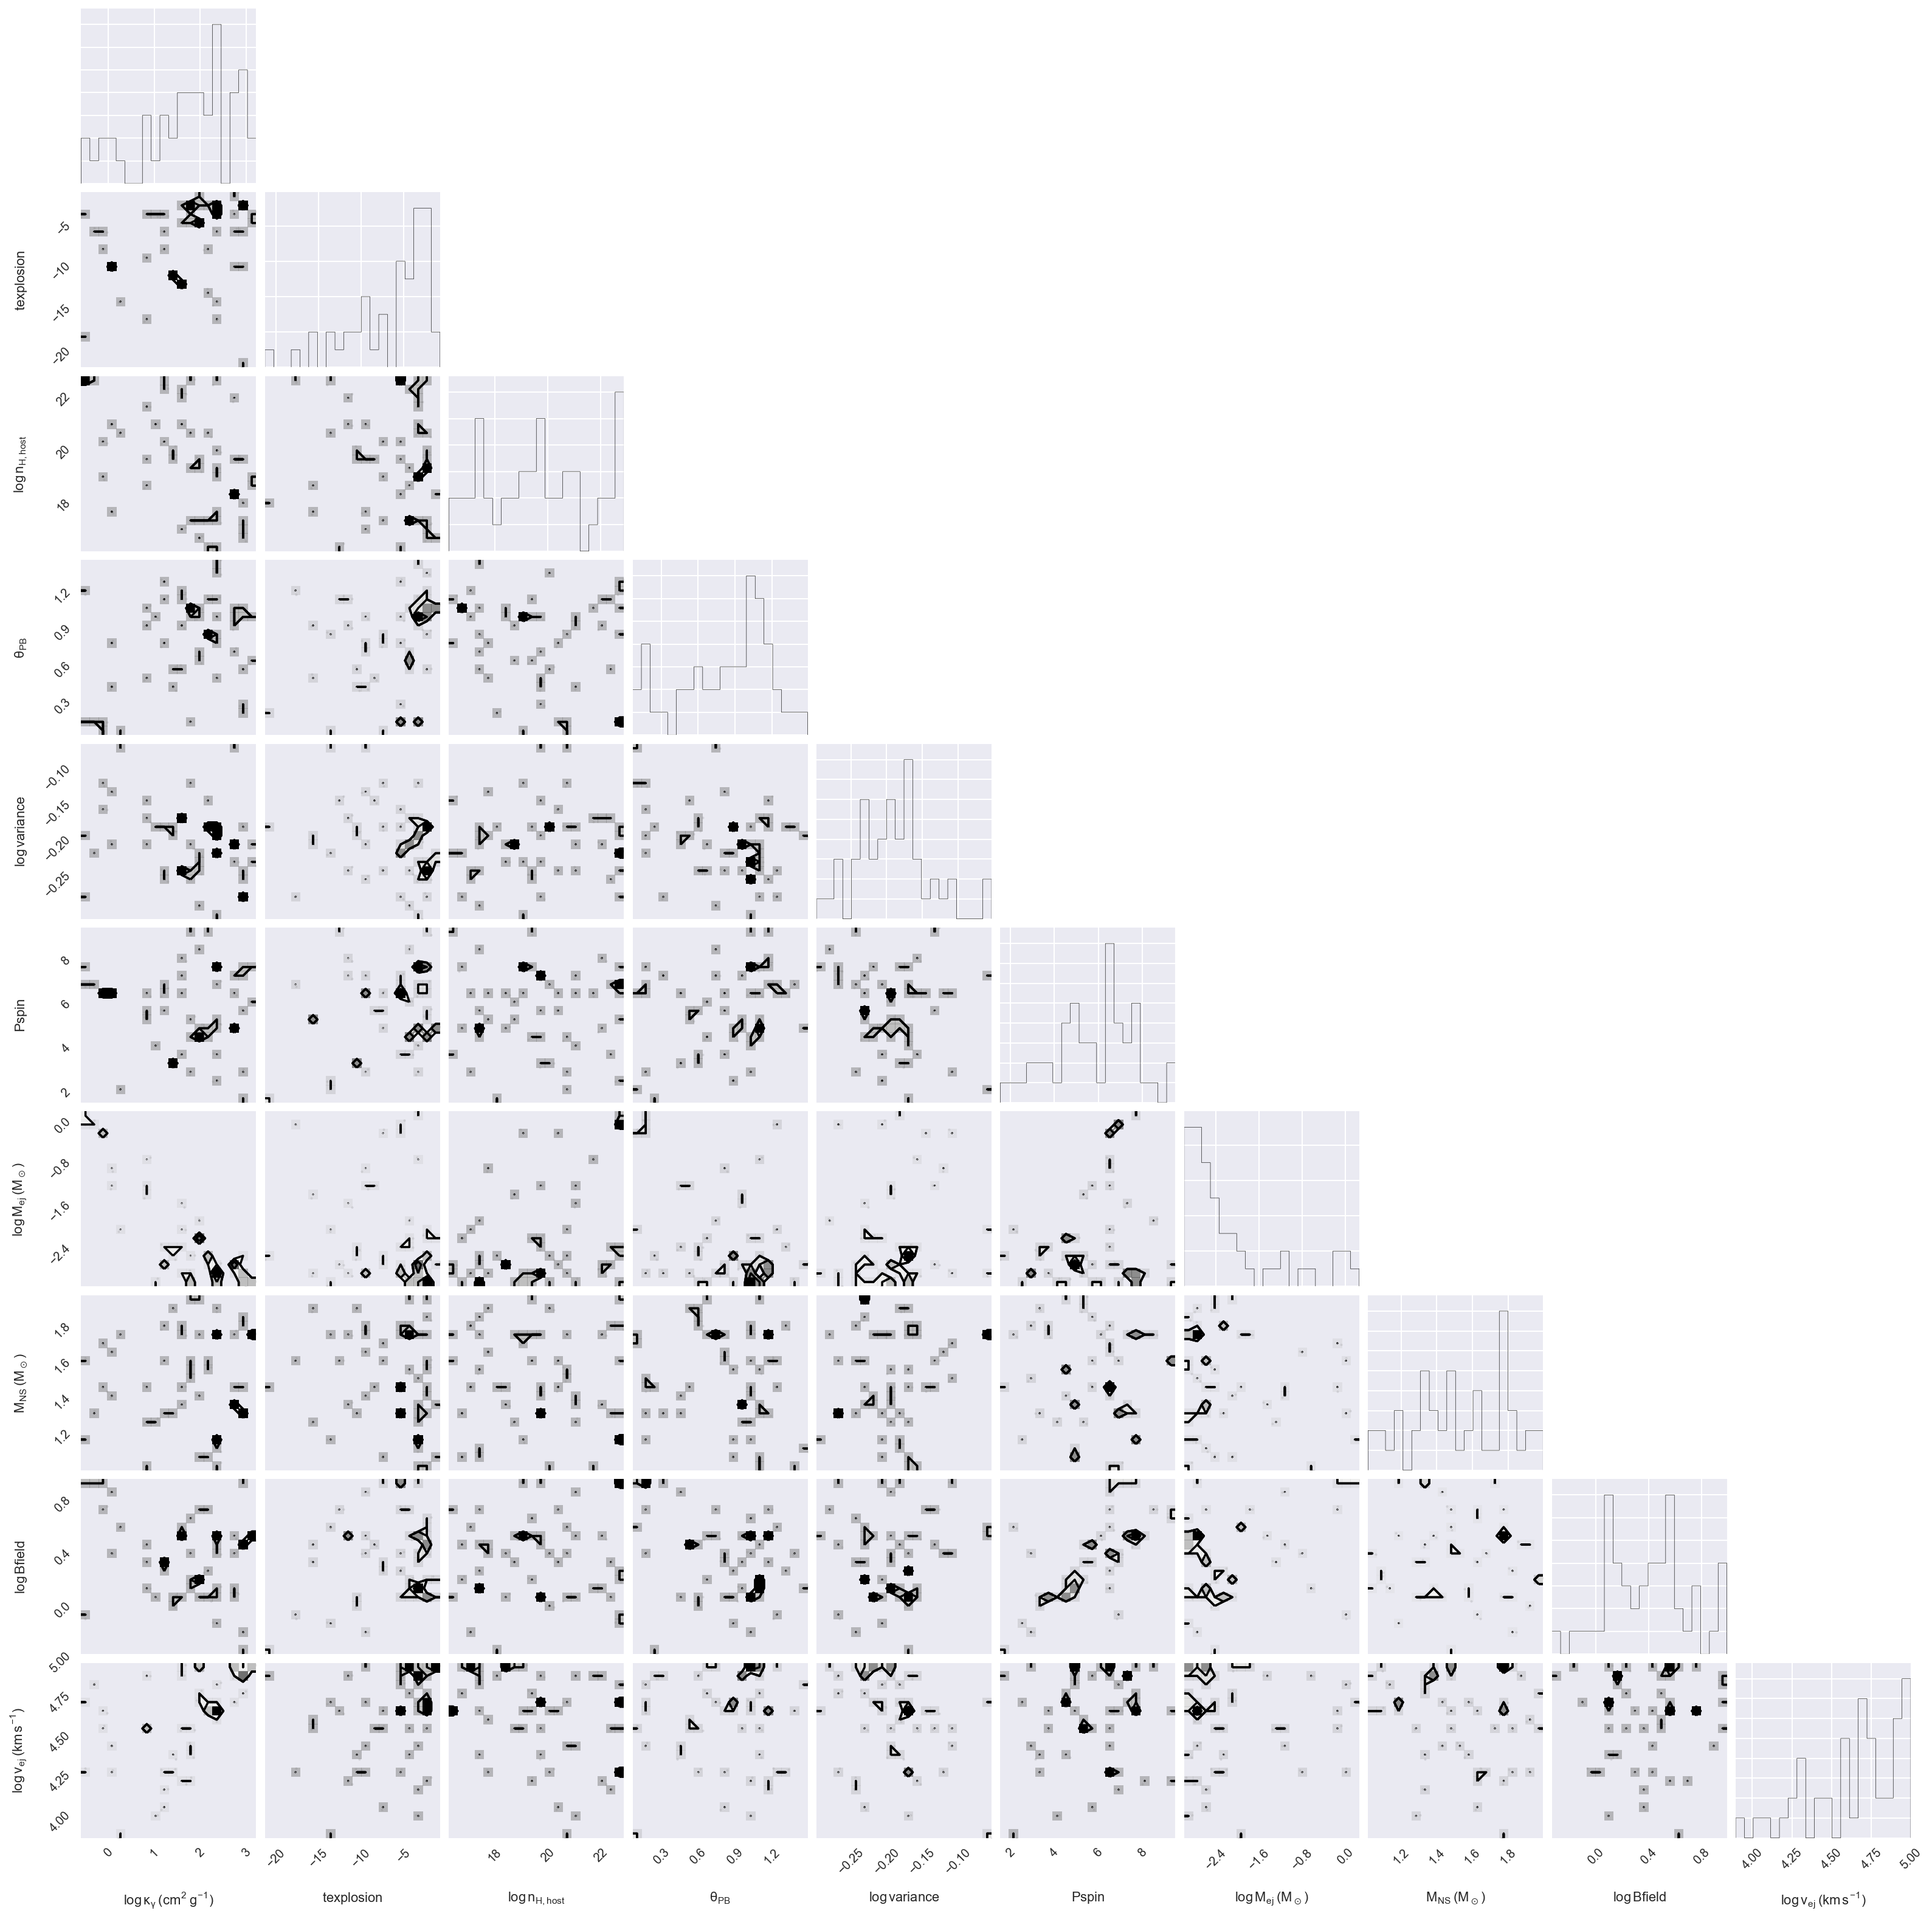

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import corner
import json
import matplotlib.pyplot as plt
import numpy as np
from mosfit.plotting import bandcolorf

with open('mosfit-products/walkers.json', 'r') as f:
    data = json.loads(f.read())
    
# Find best scoring walker
if 'score' in data['0']:
    real_data = True
    max_score = max([data[x]['score'] for x in data])
    print('Highest score: ' + str(max_score))
    for x in data:
        if data[x]['score'] == max_score:
            bdata = data[x]
            break
else:
    real_data = False
    bdata = data['0']
band_names = list(set(bdata['bands']))

fig = plt.figure(figsize=(12,6))
for band in band_names:
    xs, ys = zip(*[
        [x, y] for x, y, z in
        zip(bdata['times'], bdata['model_magnitudes'], bdata['bands'])
        if z == band])
    plt.plot(xs, ys, c=bandcolorf(band), label=('' if real_data else band))
    if real_data:
        xs, ys, yes = zip(*[
            [x, y, ye] for x, y, ye, z in
            zip(bdata['times'], bdata['magnitudes'], bdata['e_magnitudes'], bdata['bands'])
            if z == band])
        plt.errorbar(xs, ys, yerr=yes, c=bandcolorf(band), fmt='o', label=band)
plt.gca().invert_yaxis()
plt.margins(0.1,0.1)
plt.legend()
plt.show()
fig.savefig('mosfit-products/lc.pdf')

# Construct walker arrays for corner
if real_data:
    print('Preparing corner plot, takes some time.')
    corner_input = []
    for w in data:
        pars = data[w]['parameters']
        var_names = ['$' + ('\\log\\, ' if pars[x]['log'] else '') +
                     pars[x]['latex'] + '$' for x in pars]
        corner_input.append([np.log10(pars[x]['value']) if
                             pars[x]['log'] else pars[x]['value'] for x in pars])
    cfig = corner.corner(corner_input, labels=var_names)
    cfig.savefig('mosfit-products/corner.pdf')